In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)


import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV



### 1. Get the train, val, test data from the another file

[*********************100%***********************]  1 of 1 completed


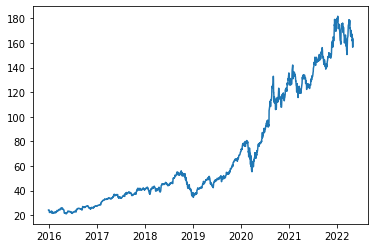

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1573 non-null   datetime64[ns]
 1   D_m3       1573 non-null   float64       
 2   D_m2       1573 non-null   float64       
 3   D_m1       1573 non-null   float64       
 4   Adj Close  1573 non-null   float64       
 5   bb_m1      1573 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.9 KB
           Date
0    2016-02-02
1    2016-02-03
2    2016-02-04
3    2016-02-05
4    2016-02-08
...         ...
1567 2022-04-22
1568 2022-04-25
1569 2022-04-26
1570 2022-04-27
1571 2022-04-28

[1572 rows x 1 columns]
         bb_m1      D_m3      D_m2      D_m1
0    -0.105413  0.007172  0.034541 -0.009349
1    -0.134903  0.034541 -0.009349 -0.020222
2    -0.108551 -0.009349 -0.020222  0.019792
3    -0.060615 -0.020222  0.019792  0.008035
4     0.042267  

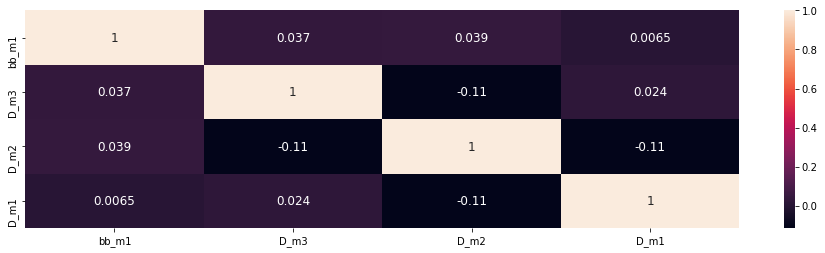

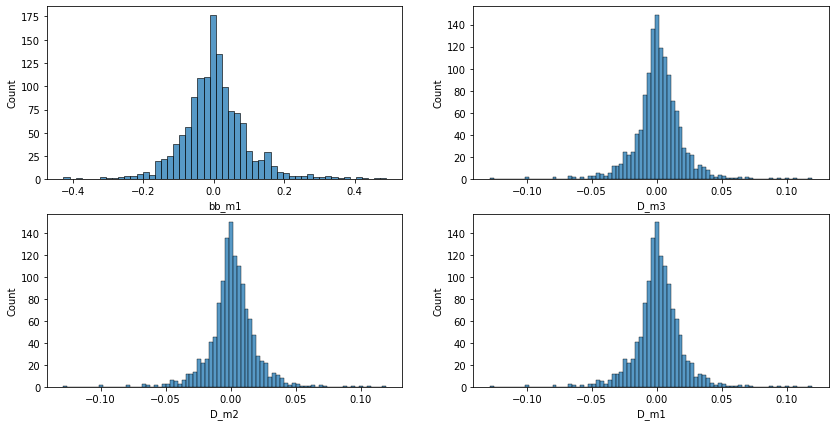

In [67]:
## Run below code to get data inclusive of Bband only with prices
%run DS105FP_ProjectScript_EdwinWan_1featureeng_final.ipynb

## Run below code to get data inclusive of MACD, MFI and BBand with prices
# %run DS105FP_ProjectScript_EdwinWan_1featureeng_initial.ipynb

### 2. Create model for XGBoost and hypertune the parameters

In [68]:
#Create the XGBoost model
model = xgb.sklearn.XGBRegressor()

In [69]:
params = {'eta': [0.1, 0.3],
          'reg_alpha': [0, 1],
          'reg_lambda': [1, 2],
          'base_score':[0.4, 0.5, 0.6], 
          'max_depth':[4,5,6],
          'subsample': [0.75, 1.0],
          'verbose': [1]
          }


In [70]:
grid = GridSearchCV(model,params, cv=None, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

[12:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a fa

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predicto

In [71]:
bp = grid.best_params_
bp

{'base_score': 0.4,
 'eta': 0.1,
 'max_depth': 4,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.75,
 'verbose': 1}

### 3. Retrain model with best params
- However, performance was lower than base model
- Base model was used instead and was save for forward testing

In [110]:
#Create the XGBoost model with best params
model = xgb.sklearn.XGBRegressor(base_score = bp['base_score'], 
                                 eta =bp['eta'], 
                                 max_depth = bp['max_depth'],
                                 reg_alpha= bp['reg_alpha'],
                                 reg_lambda= bp['reg_lambda'],
                                 subsample= bp['subsample'],
                                 verbose = 1
                                )
model.fit(x_train , y_train)

[15:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.4, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1, ...)

In [111]:
#Create prev close data
df_prev = df_train[['prev_close']]
df_prev
prev_train, prev_val, prev_test = df_prev.loc[:pct_lm-1],df_prev.loc[pct_lm:pct_um-1], df_prev.loc[pct_um:]
prev_train, prev_val, prev_test

(      prev_close
 0      22.169815
 1      21.721504
 2      22.151424
 3      22.329411
 4      21.733034
 ...          ...
 1331  126.912170
 1332  125.737152
 1333  124.323151
 1334  124.163826
 1335  126.772774
 
 [1336 rows x 1 columns],
       prev_close
 1336  124.900703
 1337  126.563660
 1338  126.364502
 1339  126.314713
 1340  124.751335
 ...          ...
 1441  148.852829
 1442  149.072220
 1443  148.284393
 1444  148.234528
 1445  148.912674
 
 [110 rows x 1 columns],
       prev_close
 1446  148.443954
 1447  152.153809
 1448  149.391357
 1449  148.553650
 1450  149.610764
 ...          ...
 1567  166.419998
 1568  161.789993
 1569  162.880005
 1570  156.800003
 1571  156.570007
 
 [126 rows x 1 columns])

In [112]:
test_predictions = model.predict(x_test)
pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])
df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3
rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

print(f"The RMSE for test set is: {rmse}")
print(f"The MAPE for test set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for test set is: 0.16358417247864748
The MAPE for test set is: 0.014566397556358605
The R2 Score for test set is: 0.8782150466987036


In [113]:
#Create the XGBoost base model
model = xgb.sklearn.XGBRegressor()
model.fit(x_train , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [114]:
df_prev = df_train[['prev_close']]
df_prev

,prev_close
0,22.169815
1,21.721504
2,22.151424
3,22.329411
4,21.733034
...,...
1567,166.419998
1568,161.789993
1569,162.880005
1570,156.800003


In [115]:
prev_train, prev_val, prev_test = df_prev.loc[:pct_lm-1],df_prev.loc[pct_lm:pct_um-1], df_prev.loc[pct_um:]
prev_train, prev_val, prev_test

(      prev_close
 0      22.169815
 1      21.721504
 2      22.151424
 3      22.329411
 4      21.733034
 ...          ...
 1331  126.912170
 1332  125.737152
 1333  124.323151
 1334  124.163826
 1335  126.772774
 
 [1336 rows x 1 columns],
       prev_close
 1336  124.900703
 1337  126.563660
 1338  126.364502
 1339  126.314713
 1340  124.751335
 ...          ...
 1441  148.852829
 1442  149.072220
 1443  148.284393
 1444  148.234528
 1445  148.912674
 
 [110 rows x 1 columns],
       prev_close
 1446  148.443954
 1447  152.153809
 1448  149.391357
 1449  148.553650
 1450  149.610764
 ...          ...
 1567  166.419998
 1568  161.789993
 1569  162.880005
 1570  156.800003
 1571  156.570007
 
 [126 rows x 1 columns])

In [116]:
train_predictions = model.predict(x_train)
train_predictions

array([-0.01563357,  0.01849714,  0.00991158, ..., -0.00234624,
        0.01630021, -0.01277229], dtype=float32)

In [117]:
pred_train = pd.DataFrame(train_predictions, columns=['pred_train'])
pred_train

,pred_train
0,-0.015634
1,0.018497
2,0.009912
3,-0.019325
4,0.007468
...,...
1331,-0.007258
1332,-0.007338
1333,-0.002346
1334,0.016300


In [118]:
df_compare = dates_train.merge(y_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(pred_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(prev_train, how='left', left_index=True, right_index=True)
df_compare['actual_close']=(df_compare['Adj Close']*df_compare['prev_close'])+df_compare['prev_close']
df_compare['pred_close']=(df_compare['pred_train']*df_compare['prev_close'])+df_compare['prev_close']
df_compare

,Date,Adj Close,pred_train,prev_close,actual_close,pred_close
0,2016-02-02,-0.020222,-0.015634,22.169815,21.721504,21.823222
1,2016-02-03,0.019792,0.018497,21.721504,22.151424,22.123290
2,2016-02-04,0.008035,0.009912,22.151424,22.329411,22.370980
3,2016-02-05,-0.026708,-0.019325,22.329411,21.733034,21.897904
4,2016-02-08,0.010530,0.007468,21.733034,21.961876,21.895332
...,...,...,...,...,...,...
1331,2021-05-17,-0.009259,-0.007258,126.912170,125.737152,125.991084
1332,2021-05-18,-0.011246,-0.007338,125.737152,124.323151,124.814438
1333,2021-05-19,-0.001282,-0.002346,124.323151,124.163826,124.031459
1334,2021-05-20,0.021012,0.016300,124.163826,126.772774,126.187723


In [119]:
rmse = np.sqrt(np.mean(df_compare['pred_close'] - df_compare['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare['actual_close'],df_compare['pred_close'])
r2 = r2_score(df_compare['actual_close'],df_compare['pred_close'])

print(f"The RMSE for train set is: {rmse}")
print(f"The MAPE for train set is: {mape}")
print(f"The R2 Score for test set is: {r2}")


The RMSE for train set is: 0.0023160892074301064
The MAPE for train set is: 0.0028511751328146326
The R2 Score for test set is: 0.9999271789699145


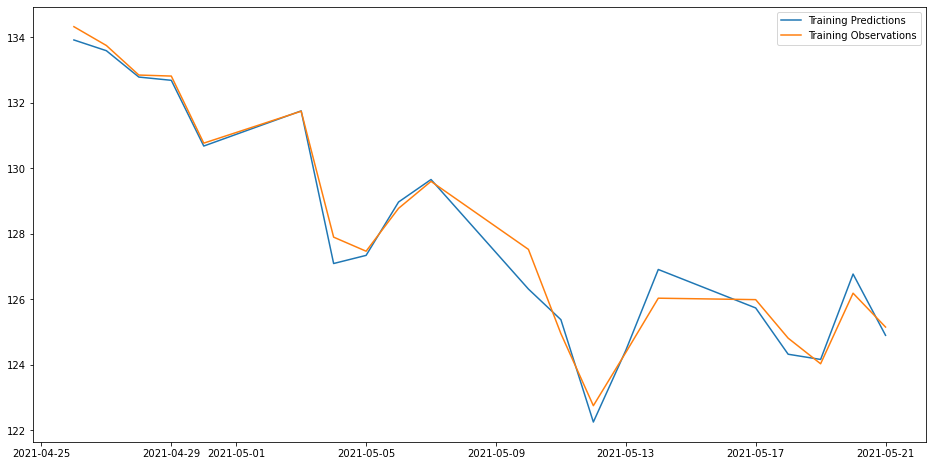

In [120]:
plt.figure(figsize=(16,8))
plt.plot(df_compare['Date'].tail(20), df_compare['actual_close'].tail(20))
plt.plot(df_compare['Date'].tail(20), df_compare['pred_close'].tail(20))
plt.legend(['Training Predictions', 'Training Observations'])



In [121]:
val_predictions = model.predict(x_val)
pred_val = pd.DataFrame(val_predictions, columns=['pred_val'])


In [122]:
df_compare2 = dates_val.reset_index(drop=True).merge(y_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(pred_val, how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(prev_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2['actual_close']=(df_compare2['Adj Close']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2['pred_close']=(df_compare2['pred_val']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2

,Date,Adj Close,pred_val,prev_close,actual_close,pred_close
0,2021-05-24,0.013314,-0.004309,124.900703,126.563660,124.362531
1,2021-05-25,-0.001574,-0.006313,126.563660,126.364502,125.764613
2,2021-05-26,-0.000394,-0.012526,126.364502,126.314713,124.781603
3,2021-05-27,-0.012377,-0.002650,126.314713,124.751335,125.980013
4,2021-05-28,-0.005348,0.010104,124.751335,124.084167,126.011877
...,...,...,...,...,...,...
105,2021-10-21,0.001474,-0.003636,148.852829,149.072220,148.311644
106,2021-10-22,-0.005285,0.000064,149.072220,148.284393,149.081739
107,2021-10-25,-0.000336,0.004127,148.284393,148.234528,148.896417
108,2021-10-26,0.004575,0.001921,148.234528,148.912674,148.519320


In [123]:
rmse = np.sqrt(np.mean(df_compare2['pred_close'] - df_compare2['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare2['actual_close'],df_compare2['pred_close'])
r2 = r2_score(df_compare2['actual_close'],df_compare2['pred_close'])

print(f"The RMSE for validation set is: {rmse}")
print(f"The MAPE for validation set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for validation set is: 0.0229253296489693
The MAPE for validation set is: 0.011691211665717344
The R2 Score for test set is: 0.9394739917604897


In [124]:
test_predictions = model.predict(x_test)
pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])

In [125]:
df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3

,Date,Adj Close,pred_test,prev_close,actual_close,pred_close
0,2021-10-28,0.024992,-0.000947,148.443954,152.153809,148.303336
1,2021-10-29,-0.018156,0.009506,152.153809,149.391357,153.600192
2,2021-11-01,-0.005607,-0.013158,149.391357,148.553650,147.425706
3,2021-11-02,0.007116,0.006325,148.553650,149.610764,149.493251
4,2021-11-03,0.009799,0.013479,149.610764,151.076767,151.627333
...,...,...,...,...,...,...
121,2022-04-22,-0.027821,-0.003234,166.419998,161.789993,165.881836
122,2022-04-25,0.006737,0.002538,161.789993,162.880005,162.200683
123,2022-04-26,-0.037328,-0.003705,162.880005,156.800003,162.276512
124,2022-04-27,-0.001467,-0.001501,156.800003,156.570007,156.564686


In [126]:
rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

print(f"The RMSE for test set is: {rmse}")
print(f"The MAPE for test set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for test set is: 0.08670687264476457
The MAPE for test set is: 0.01555642603832342
The R2 Score for test set is: 0.8608040393433748


In [127]:
max(df_compare3['pred_test'] - df_compare3['Adj Close'])

0.039174024010863895

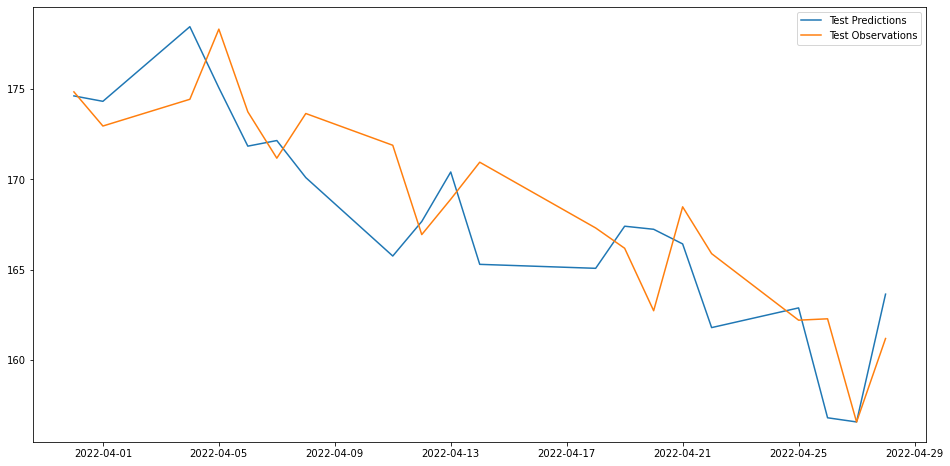

In [128]:
plt.figure(figsize=(16,8))
plt.plot(df_compare3['Date'].tail(20), df_compare3['actual_close'].tail(20))
plt.plot(df_compare3['Date'].tail(20), df_compare3['pred_close'].tail(20))
plt.legend(['Test Predictions', 'Test Observations'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

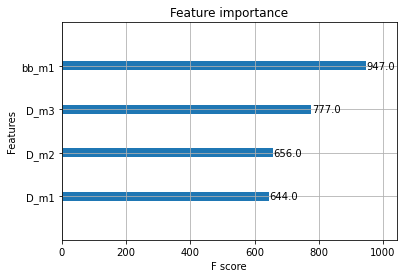

In [129]:
xgb.plot_importance(model)

### 4. Save model using pickle

In [130]:
import pickle
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)